In [8]:
from keras.models import Model
from keras.layers import Dense, Input, Lambda, Concatenate

from keras import backend as K

from keras.datasets import mnist

import tensorflow as tf
import tensorflow_probability as tfp # for tf version 2.0.0, tfp version 0.8 is needed 
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [9]:
tf.test.is_gpu_available()

True

In [10]:
import cv2

In [11]:
import matplotlib.pyplot as plt
import os, time  
import numpy as np 
from keras.preprocessing.image import img_to_array
dir_data      = "data/img_align_celeba/"
Ntrain        = 1000 
Ntest         = 100
nm_imgs       = np.sort(os.listdir(dir_data))
## name of the jpg files for training set
nm_imgs_train = nm_imgs[:Ntrain]
## name of the jpg files for the testing data
nm_imgs_test  = nm_imgs[Ntrain:Ntrain + Ntest]
img_shape     = (32, 32, 3)

def get_npdata(nm_imgs_train):
    X_train = []
    for i, myid in enumerate(nm_imgs_train):
        image = cv2.imread(dir_data + "/" + myid) #,
                         #target_size=img_shape[:2])
        image = img_to_array(image)/255.0
        X_train.append(image)
    X_train = np.array(X_train)
    return(X_train)

X_train = get_npdata(nm_imgs_train)
print("X_train.shape = {}".format(X_train.shape))

X_test  = get_npdata(nm_imgs_test)
print("X_test.shape = {}".format(X_test.shape))

X_train.shape = (1000, 218, 178, 3)
X_test.shape = (100, 218, 178, 3)


In [28]:
import matplotlib.pyplot as plt
for i in range(len(X_train)):
    X_train[i] =  X_train[i][..., ::-1]
for i in range(len(X_test)):
    X_test[i] =  X_test[i][..., ::-1]

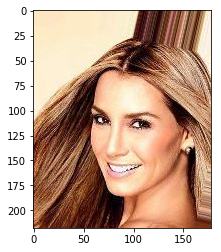

In [29]:
plt.imshow(X_train[0])

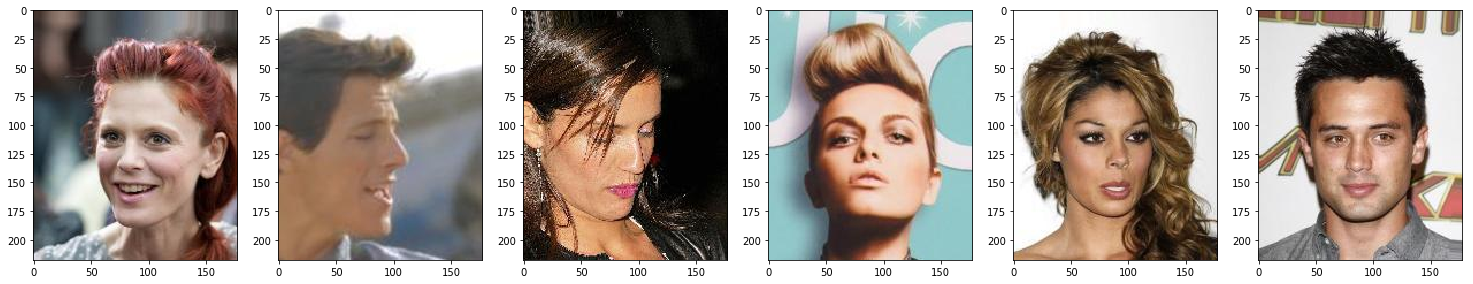

In [19]:
fig = plt.figure(figsize=(30,10))
nplot = 7
for count in range(1,nplot):
    ax = fig.add_subplot(1,nplot,count)
    ax.imshow(cv2.cvtColor(X_train[count], cv2.COLOR_BGR2RGB))
plt.show()

In [14]:
cv2.cvtColor(X_train[0], cv2.COLOR_BGR2GRAY).shape

(218, 178)

In [15]:
# x_train = np.zeros([Ntrain, 218, 178])
# x_test = np.zeros([Ntest, 218, 178])
# for i in range(len(x_train)):
#     x_train[i] =  cv2.cvtColor(X_train[i], cv2.COLOR_BGR2GRAY)
# for i in range(len(x_test)):
#     x_test[i] =  cv2.cvtColor(X_test[i], cv2.COLOR_BGR2GRAY)

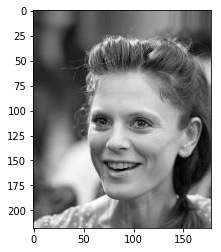

In [27]:
plt.imshow(cv2.cvtColor(X_train[1], cv2.COLOR_BGR2GRAY), cmap='gray', vmin=0, vmax=1)
# cv2.cvtColor(X_train[0], cv2.COLOR_BGR2GRAY).shape

---

In [44]:
# input image dimensions
img_rows, img_cols, channels = 218, 178, 3

# # the data, split between train and test sets
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

---

In [31]:
def img_coordinates(img_rows, img_cols):
    # [img_rows, img_cols]
    row_dim = np.tile(np.expand_dims(np.arange(0., 1., 1. / img_rows, dtype='float32'), axis=0), [img_cols,1])
    # [img_cols, img_rows]
    col_dim = np.tile(np.expand_dims(np.arange(0., 1., 1. / img_cols, dtype='float32'), axis=0), [img_rows,1])
    # [img_rows*img_cols, 2]
    x_pairs = np.reshape(np.concatenate((np.expand_dims(np.transpose(row_dim), axis=-1), np.expand_dims(col_dim, axis=-1)), axis=-1), [img_rows*img_cols,2])
    
    return x_pairs

In [45]:
def generate_data(batch_size, max_num_context, testing=False, img_rows = 218, img_cols = 178):
    
    max_num_points = img_rows*img_cols
    
    if max_num_context > max_num_points:
        num_context = np.random.randint(3, max_num_points, dtype='int32')
    else:
        num_context = np.random.randint(3, max_num_context, dtype='int32')
    
    if testing:
        num_target_points = max_num_points
        set_x = X_test
    else:
        num_target_points = np.random.randint(num_context, max_num_points+1, dtype='int32')
        set_x = X_train
    
    context_x = np.zeros([batch_size, num_context, 2])
    context_y = np.zeros([batch_size, num_context, channels])
    
    target_x = np.zeros([batch_size, num_target_points, 2])
    target_y = np.zeros([batch_size, num_target_points, channels])
    
    x_pairs = img_coordinates(img_rows, img_cols)
    
    idx_1 = np.arange(set_x.shape[0])
    np.random.shuffle(idx_1)
        
    for i in range(batch_size):
        
        img = np.reshape(set_x[idx_1[i]], [max_num_points, channels])/255
        
        idx_2 = np.arange(max_num_points)
        np.random.shuffle(idx_2)
        
        context_x[i] = x_pairs[idx_2[:num_context]]
        context_y[i] = img[idx_2[:num_context]]
        
        if testing:
            target_x[i] = x_pairs
            target_y[i] = img
        else:
            target_x[i] = x_pairs[idx_2[:num_target_points]]
            target_y[i] = img[idx_2[:num_target_points]]


    context_xy = np.concatenate([context_x, context_y], axis=-1)
    
    return [context_xy, target_x], target_y   

In [46]:
def generate(batch_size, max_num_context, testing):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        inputs, targets = generate_data(batch_size, max_num_context, testing=testing)
        yield (inputs, targets)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


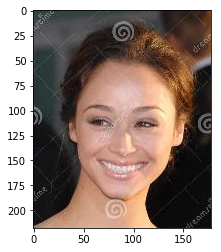

In [47]:
[context_xy, target_x], target_y = generate_data(1, 218*178, testing=True, img_rows = 218, img_cols = 178)
plt.imshow(np.array(target_y[0]).reshape([218,178,3])*255)

In [50]:
target_y.shape

(1, 38804, 3)

___


In [48]:
def log_prob(y_true, y_pred):
    mu, sigma = tf.split(y_pred, 2, axis=-1)

    dist = tfp.distributions.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    log_p = dist.log_prob(y_true)
    
    loss = -K.mean(log_p)
    
    return loss

___


In [52]:
"""encoder"""
input_context_xy = Input((None, 2+channels), name="Input_layer_contxt_xy") # [num_pts, 2]
input_target_x = Input((None, 2), name="Input_layer_target_x")  # [num_pts, 1]

encoder = input_context_xy

encoder = Dense(128, activation='relu', name="Encoder_layer_0")(encoder)
encoder = Dense(128, activation='relu', name="Encoder_layer_1")(encoder)
encoder = Dense(128, activation='relu', name="Encoder_layer_2")(encoder)
representation_r_i = Dense(128, activation='linear', name="Encoder_layer_3")(encoder)


"""aggregate"""
representation_r = Lambda(lambda x: K.mean(x, axis=-2), name="Mean_layer_r")(representation_r_i)


"""decoder"""
representation_r_tiled = Lambda(lambda x: K.tile(K.expand_dims(x, axis=-2), [1, K.shape(input_target_x)[-2], 1]), name="Tile_layer_r")(representation_r)

decoder_input = Concatenate(axis=-1, name="Concat_layer_r_target_x")([representation_r_tiled, input_target_x])
decoder = Dense(128, activation='relu', name="Decoder_layer_0")(decoder_input)
decoder = Dense(128, activation='relu', name="Decoder_layer_1")(decoder)
decoder = Dense(128, activation='relu', name="Decoder_layer_2")(decoder)
decoder = Dense(128, activation='relu', name="Decoder_layer_3")(decoder)
decoder = Dense(2*channels, activation='linear', name="Decoder_layer_4")(decoder)

mu, log_sigma = Lambda(lambda x: tf.split(x, 2, axis=-1), name="Split_layer")(decoder)
sigma = Lambda(lambda x: 0.1 + 0.9 * K.softplus(x), name="Softplus_layer_sigma")(log_sigma)


"""build model"""
output = Concatenate(axis=-1, name="Concat_layer_mu_sigma")([mu, sigma])

model = Model([input_context_xy, input_target_x], output)

model.compile(loss=log_prob, optimizer='adam')

model.summary()

# model.load_weights("CNP_mnist_e3_d5_v1.h5")

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_layer_contxt_xy (InputLay (None, None, 5)      0                                            
__________________________________________________________________________________________________
Encoder_layer_0 (Dense)         (None, None, 128)    768         Input_layer_contxt_xy[0][0]      
__________________________________________________________________________________________________
Encoder_layer_1 (Dense)         (None, None, 128)    16512       Encoder_layer_0[0][0]            
__________________________________________________________________________________________________
Encoder_layer_2 (Dense)         (None, None, 128)    16512       Encoder_layer_1[0][0]            
____________________________________________________________________________________________

___


In [53]:
def plot_functions(inputs, target_y, labels_y, pred, scale=1):
    
    target_y = np.array(target_y[0]).reshape([(img_cols*scale),(img_rows*scale)])
    label = labels_y[0,0]

    context_x = np.array(np.round(np.matmul(inputs[0][0, :, 0:2], [[img_rows, 0], [0, img_cols]])), dtype='uint16')
    context_y = np.array(np.round(inputs[0][0, :, 2]*255), dtype='uint8')

    context_img = np.zeros([img_rows, img_cols, 3], dtype='uint8')
    context_img[:,:,2] = 255 # set background blue
    for i in range(context_x.shape[0]):
        context_img[context_x[i,0], context_x[i,1], :] = 255 - context_y[i]

    pred_y = np.array(pred[0, :, 0]).reshape([(img_cols*scale),(img_rows*scale)])
    var = np.array(pred[0, :, 1]).reshape([(img_cols*scale),(img_rows*scale)])    

    fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2, 2, figsize=(6,6))
    ax1.imshow(target_y, cmap='Greys', vmin=0, vmax=1)
    if scale==1:
        ax1.set_title("True", fontsize = 12)
    else:
        ax1.set_title("True \n (upsampled using \n nearest neighbour)", fontsize = 12)
    ax2.imshow(pred_y, cmap='Greys', vmin=0, vmax=1)
    ax2.set_title("Predict", fontsize = 12)

    ax3.imshow(context_img)
    ax3.set_title("Context Points: Num pts=%i/%i" % (context_x.shape[0], img_rows*img_cols), fontsize = 12)

    ax4.imshow(var, cmap='Greys', vmin=0, vmax=1)
    ax4.set_title("Variance", fontsize = 12)

    fig.suptitle("Digit: %i" % label, fontsize = 14)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)

    plt.show()

---

In [54]:
MAX_CONTEXT_POINTS = 5e2

repeats = 20
epochs = 50
steps_per_epoch = 2e2
steps_per_validation = 2e2
batch_size = 1

log: r20, e50, spe2e2, spv1e2, b64 &nbsp;&nbsp;&nbsp; CNP_mnist_e3_d5_v1.h5<br>
Total Train: 200000 iterations of batch size 64<br>


In [55]:
print('Training model')

hist = np.zeros([2, repeats*epochs], dtype='float32')

for i in range(repeats):
    print("*****************************")
    print("Repeat %i" % (i+1))
    history = model.fit_generator(
                    generate(batch_size, MAX_CONTEXT_POINTS, testing=False),
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=generate(1, MAX_CONTEXT_POINTS, testing=True),
                    validation_steps=steps_per_validation)
    
    hist[0,i*epochs:(i+1)*epochs] = history.history['loss']
    hist[1,i*epochs:(i+1)*epochs] = history.history['val_loss']
    
    inputs, target_y, labels_y = generate_data(1, MAX_CONTEXT_POINTS, testing=True, labels = True)
    pred = model.predict(inputs, steps=1)

    plot_functions(inputs, target_y, labels_y, pred)
    
# model.save_weights("CNP_mnist_e3_d5_v1.h5")

Training model
*****************************
Repeat 1
Epoch 1/50
200/200 [==============================] - 8s 38ms/step - loss: -3.7186 - val_loss: -4.1420
Epoch 2/50
200/200 [==============================] - 7s 36ms/step - loss: -4.1247 - val_loss: -4.1474
Epoch 3/50
200/200 [==============================] - 7s 33ms/step - loss: -4.1307 - val_loss: -4.1257
Epoch 4/50
200/200 [==============================] - 7s 33ms/step - loss: -4.1397 - val_loss: -4.1448
Epoch 5/50
200/200 [==============================] - 7s 35ms/step - loss: -4.1399 - val_loss: -4.1490
Epoch 6/50
 41/200 [=====>........................] - ETA: 3s - loss: -4.1395

ResourceExhaustedError:  OOM when allocating tensor with shape[128,6] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradients/Decoder_layer_4/MatMul_grad/MatMul_1 (defined at /homes/wy261/Documents/testenv/lib/python3.5/site-packages/tensorflow_core/python/framework/ops.py:1751) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_3434]

Function call stack:
keras_scratch_graph


In [97]:
inputs, target_y, labels_y = generate_data(1, 500, testing=True, digit=3, labels = True)
pred = model.predict(inputs, steps=1)

plot_functions(inputs, target_y, labels_y, pred)

NameError: name 'img_cols' is not defined

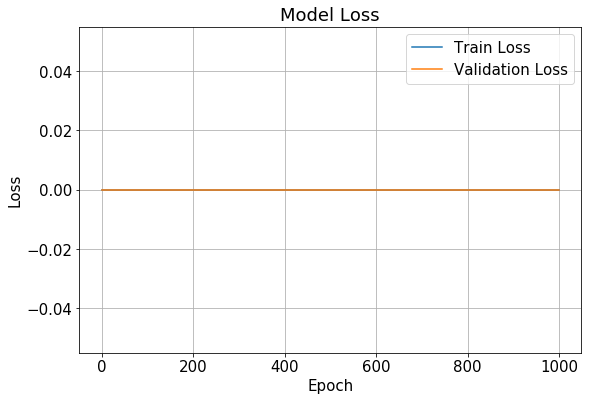

In [98]:
plt.figure(figsize=(9,6))
plt.plot(hist[0])
plt.plot(hist[1])
plt.title('Model Loss', fontsize=18)
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Epoch', fontsize=15)
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.grid()
plt.show()

In [100]:
img_rows = 218 
img_cols = 178

In [101]:
max_num_points = img_rows*img_cols
num_context = 28*28 # for half image: set to 420 and comment Randomise line below

idx_1 = np.arange(x_test.shape[0])
np.random.shuffle(idx_1)



# img_index = 61                  # Specific image
# img_index = idx_1[0]          # Any random digit
digit = 8                       # Specific digit
for j in range(x_test.shape[0]): 
    if digit == y_test[idx_1[j]]:
        img_index = idx_1[j]
        break



labels_y = np.zeros([1, 1], dtype='int8')
labels_y[0] = y_test[img_index]

img = np.reshape(x_test[img_index], [max_num_points,1])/255
x_pairs = img_coordinates(img_rows, img_cols)

idx_2 = np.arange(max_num_points)



np.random.shuffle(idx_2)  # Comment: ordered context pts, Uncomment: random context pts



context_x = np.zeros([1, num_context, 2])
context_y = np.zeros([1, num_context, 1])

context_x[0] = x_pairs[idx_2[:num_context]]
context_y[0] = img[idx_2[:num_context]]



scale = 10
max_num_points = (img_rows*scale)*(img_cols*scale)

img = x_test[img_index]/255
x_pairs = img_coordinates((img_rows*scale),(img_cols*scale))

target_x = np.zeros([1, max_num_points, 2])
target_y = np.zeros([1, max_num_points, 1])

target_x[0] = x_pairs
target_y[0] = np.reshape(img.repeat(scale, axis=0).repeat(scale, axis=1), [max_num_points,1])


context_xy = np.concatenate([context_x, context_y], axis=-1)  
inputs = [context_xy, target_x]
pred = model.predict(inputs, steps=1)

plot_functions(inputs, target_y, labels_y, pred, scale=scale)


ResourceExhaustedError:  OOM when allocating tensor with shape[1,3880400,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Tile_layer_r_3/Tile (defined at /homes/wy261/Documents/testenv/lib/python3.5/site-packages/tensorflow_core/python/framework/ops.py:1751) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_59939]

Function call stack:
keras_scratch_graph
